# Example: Generating Synthetic Video Data from Configuration

This notebook demonstrates the complete pipeline for generating synthetic microtubule video data using the SynthMT framework. Starting from a JSON configuration file, we generate realistic microscopy videos with corresponding instance segmentation masks.

## Pipeline Overview

The generation process follows the two-step stochastic framework:

1. **Geometry Generation**: Create microtubule polylines with stochastic curvature
2. **Image Rendering**: Apply PSF convolution, noise, and artifacts

For videos, we additionally simulate **microtubule dynamics**:
- **Growing**: Plus-end polymerization
- **Shrinking**: Catastrophe-induced depolymerization
- **Pausing**: Temporary growth arrest
- **Rescue**: Recovery from shrinkage

The output includes images, masks, videos, and preview animations.

In [11]:
import os

from IPython.display import Image, display
from matplotlib import pyplot as plt
import imageio.v2 as imageio

from examples.utils import create_overlay
from synth_mt.config.synthetic_data import SyntheticDataConfig
from synth_mt.data_generation.video import generate_video

## Setup Paths and Output Directory

The generation pipeline writes multiple output files organized in subdirectories:
- `configs/` - JSON configuration used for reproducibility
- `images/` - Individual PNG frames
- `image_masks/` - Per-frame TIFF instance masks
- `videos/` - Full video as TIFF stack
- `previews/` - GIF/MP4 previews for quick inspection


In [12]:
cfg_path = "synthetic_data_example.json"
output_folder = "synthetic_data_output"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

## Load Configuration

The `SyntheticDataConfig` class encapsulates all parameters $\theta$ for the generation process:

### Geometry Parameters
- `num_microtubule`: Number of MTs to simulate
- `microtubule_length_min/max`: Length distribution bounds
- `bending_angle_gamma_shape/scale`: Curvature statistics ($\alpha$, $\beta$)
- `prob_to_flip_bend`, `max_angle_sign_changes`: Bend direction control

### Dynamics Parameters
- `growth_speed`, `shrink_speed`: Plus-end velocity (pixels/frame)
- `catastrophe_prob`, `rescue_prob`: State transition probabilities
- `max_pause_at_min_frames`: Forced rescue after pause duration

### Rendering Parameters
- `psf_sigma_h/v`: Point spread function widths
- `background_level`, `tubulus_contrast`: Intensity settings
- `quantum_efficiency`, `gaussian_noise`: Noise model
- `vignetting_strength`, `global_blur_sigma`: Global effects

### Artifact Parameters
- `fixed_spots`, `moving_spots`, `random_spots`: Distractor configurations

In [13]:
# Load the configuration from the JSON file
cfg = SyntheticDataConfig.from_json(cfg_path)

### Show Configuration Details

Print all parameters to verify the configuration. These values define the probability distribution $P_\theta(I)$ over generated images.

In [14]:
for key, value in cfg.asdict().items():
    print(f"{key}: {value}")

id: 0
img_size: (512, 512)
num_frames: 50
fps: 10
num_microtubule: 15
microtubule_seed_min_dist: 50
margin: 5
growth_speed: 2.5
shrink_speed: 5.0
catastrophe_prob: 0.05
rescue_prob: 0.05
max_pause_at_min_frames: 50
growth_speed_std: 0.0
shrink_speed_std: 0.0
catastrophe_prob_std: 0.0
rescue_prob_std: 0.0
base_wagon_length_min: 10.0
base_wagon_length_max: 50.0
microtubule_length_min: 100
microtubule_length_max: 200
tail_wagon_length: 10.0
bending_angle_gamma_shape: 1.0
bending_angle_gamma_scale: 0.02
max_angle_sign_changes: 5
prob_to_flip_bend: 0.9
minus_end_target_length_mean: 0.0
minus_end_target_length_std: 20.0
minus_end_velocity: 1.0
psf_sigma_h: 0.4
psf_sigma_v: 0.7
tubule_width_variation: 0.1
background_level: 0.9
tubulus_contrast: -0.4
seed_red_channel_boost: 0.5
tip_brightness_factor: 1.2
red_channel_noise_std: 0.05
quantum_efficiency: 100.0
gaussian_noise: 0.3
vignetting_strength: 0.05
global_blur_sigma: 0.6
jitter_px: 0.5
fixed_spots: {'count': 1000, 'intensity_min': -0.3, 'i

## Generate Synthetic Video Data

The `generate_video` function performs the complete generation pipeline:

1. **Initialize** microtubules with random positions, orientations, and lengths
2. **For each frame**:
   - Update MT states (growing/shrinking/paused) based on transition probabilities
   - Update MT lengths based on growth/shrink speeds
   - Render all MTs with PSF convolution
   - Add spots and artifacts
   - Apply noise (Poisson + Gaussian)
   - Apply global effects (vignetting, blur, contrast)
3. **Export** all outputs to the specified folder

⏱️ Generation time depends on `num_frames`, `num_microtubule`, and `img_size`.


In [15]:
frames = generate_video(cfg, output_folder)

Series 0 frames: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


## Output Files Generated

The pipeline creates a comprehensive set of outputs in `output_folder/full/`:

| Folder | Format | Description |
|--------|--------|-------------|
| `configs/` | JSON | Configuration snapshot for reproducibility |
| `gt/` | JSON | Ground truth: segment positions, lengths, types per frame |
| `images/` | PNG | Individual RGB frames (8-bit) |
| `images_tiff/` | TIFF | Individual frames (16-bit, lossless) |
| `image_masks/` | TIFF | Per-frame instance masks (16-bit labels) |
| `image_masks_colored/` | PNG | Colored mask visualizations |
| `videos/` | TIFF | Full video stack (T×H×W×C) |
| `video_masks/` | TIFF | Full mask video stack (T×N×H×W) |
| `previews/` | GIF, MP4 | Animated previews for quick inspection |

### File Naming Convention

- `series_{id}_frame_{frame_idx:04d}.png`
- `series_{id}_frame_{frame_idx:04d}.tif`
- `series_{id}_video.tif`
- `series_{id}_video.json`


## Visualize Generated Frames with Mask

Load the exported frames and corresponding masks to verify generation quality. The overlay visualization shows each instance in a distinct color.

In [16]:
# Load exported frames and masks

frames_folder = os.path.join(output_folder, "full", "images")
frame_masks_folder = os.path.join(output_folder, "full", "image_masks")

frame_paths = sorted(os.listdir(frames_folder))
frame_mask_paths = sorted(os.listdir(frame_masks_folder))

print(f"Number of frames: {len(frame_paths)}")
print(f"Number of frame masks: {len(frame_mask_paths)}")

Number of frames: 55
Number of frame masks: 55


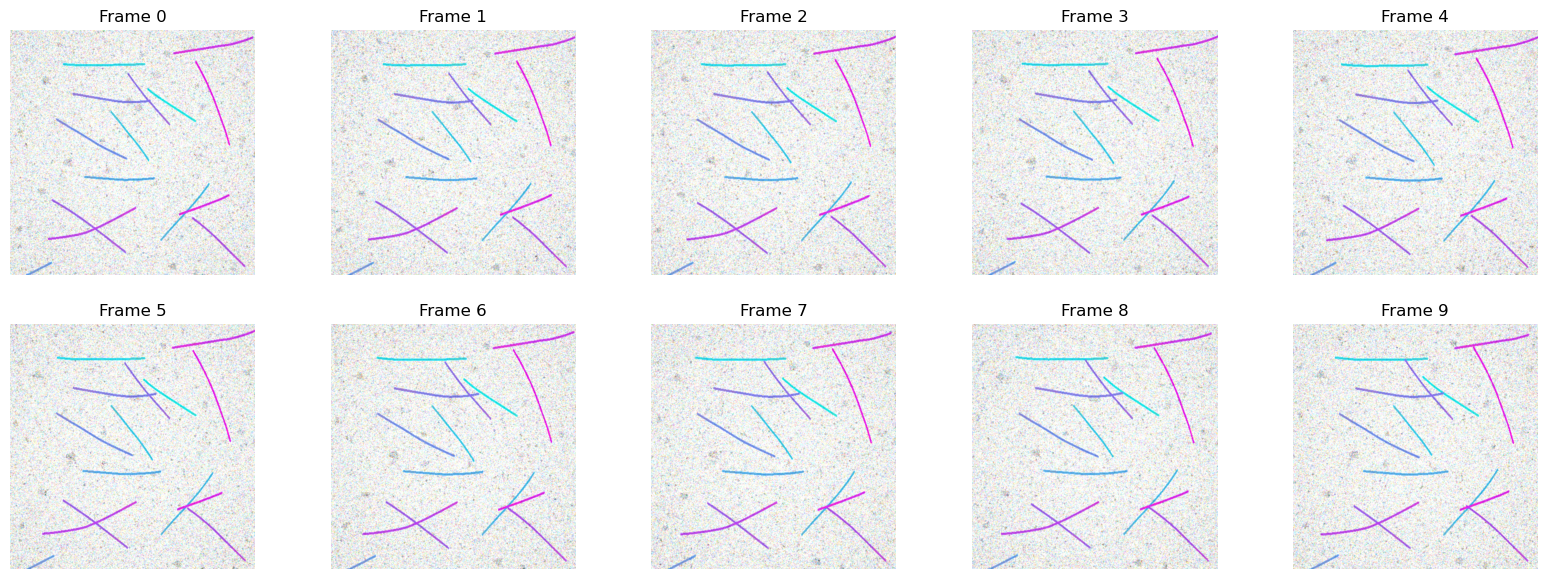

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(20, 7))
axs = axs.flatten()

for ax, idx in zip(axs, range(10)):
    frame = imageio.imread(os.path.join(frames_folder, frame_paths[idx]))
    mask = imageio.imread(os.path.join(frame_masks_folder, frame_mask_paths[idx]))

    overlay = create_overlay(frame, mask)

    ax.imshow(overlay)
    ax.axis("off")
    ax.set_title(f"Frame {idx}")

## Display Generated GIF Previews

The pipeline automatically generates animated GIF previews for quick visual inspection:

- **Video preview**: Shows the rendered microscopy video
- **Mask preview**: Shows the instance segmentation masks with colored labels

These are useful for:
- Verifying MT dynamics (growth, shrinkage, catastrophe, rescue)
- Checking mask quality and instance tracking
- Quick parameter tuning before generating large datasets

In [18]:
gif_path_video = os.path.join(output_folder, "full", "previews", f"series_{cfg.id}_video_preview.gif")
gif_path_mask = os.path.join(output_folder, "full", "previews", f"series_{cfg.id}_masks_preview.gif")

In [19]:
display(Image(filename=gif_path_video))

In [20]:
display(Image(filename=gif_path_mask))